# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

We'll try to write some TensorFlow code to predict the price of Bitcoin based on the historical data of the Bitcoin itself.

## Get data
We're going to be using historical price data of BTC. Data has been downloaded from Yahoo Finance service.

In [1]:
# Import data with pandas
import pandas as pd

# Read in BTC data and pass the dates
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas that column 1 is datetime format

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [2]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-03,28680.494141,29259.533203,28178.388672,29006.308594,29006.308594,19122972518
2023-05-04,29031.304688,29353.185547,28694.039063,28847.710938,28847.710938,15548678514
2023-05-05,28851.480469,29668.908203,28845.509766,29534.384766,29534.384766,17936566518
2023-05-06,29538.859375,29820.126953,28468.966797,28904.623047,28904.623047,15913866714
2023-05-07,28916.708984,29151.941406,28788.570313,28897.636719,28897.636719,11557177344


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3155 entries, 2014-09-17 to 2023-05-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3155 non-null   float64
 1   High       3155 non-null   float64
 2   Low        3155 non-null   float64
 3   Close      3155 non-null   float64
 4   Adj Close  3155 non-null   float64
 5   Volume     3155 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 172.5 KB


In [4]:
# How many samples do we have?
len(df)

3155

In [5]:
# How many years is this?
3155/365

8.643835616438356

We've collected the historical price of BTC (from past 8,5 years or so) which gave exactly 3155 samples. 

Typically deep learning models thrive when being fed lots and lots of samples (where 'lots and lots' can be millions or more). 

A smaller number of samples is something you'll often run into while working with the time series problem.

> **NOTE**: The *seasonality* of a time series dataset is referred as the number of samples per year in given series. For our BTC data, it has seasonality of *daily* or value of *365* which speaks for itself.

In [6]:
# Only leave the closing price per each day
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns={'Close': 'Price'})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-03,29006.308594
2023-05-04,28847.710938
2023-05-05,29534.384766


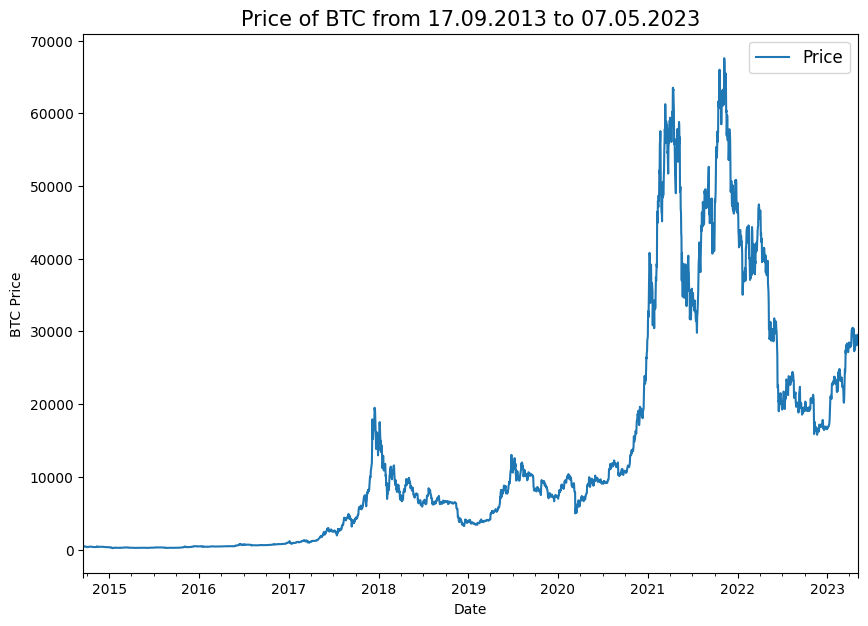

In [7]:
# Visualize the BTC price
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))
plt.ylabel('BTC Price')
plt.title('Price of BTC from 17.09.2013 to 07.05.2023', fontsize=15)
plt.legend(fontsize=12)

## Importing time series data with Python's CSV module

In [8]:
# Importing and formatting data with Python CSV library
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv", 'r') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=",")
  next(csv_reader) # goes through the iterator and ignores/skips next line - first line in our example
  
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates, not as strings
    btc_price.append(float(line[4])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Text(0, 0.5, 'BTC price')

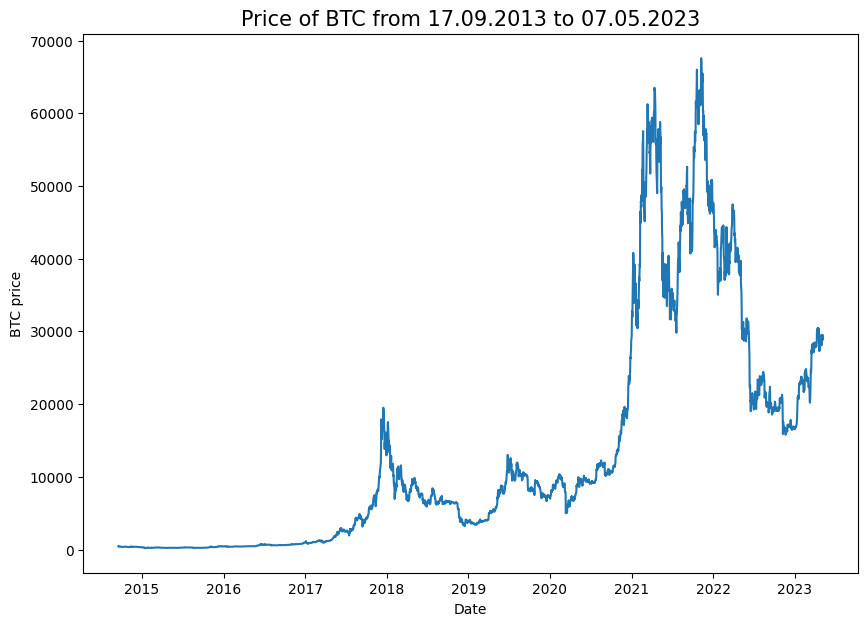

In [9]:
# Plot from Python CSV
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.title("Price of BTC from 17.09.2013 to 07.05.2023", fontsize=15)
plt.xlabel("Date")
plt.ylabel("BTC price")

## Format data part 1: Create train and test sets of our times series data

### Creating training and test sets with time series data (the wrong way)

In [10]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988]))

In [11]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2524,), (631,), (2524,), (631,))

Text(0.5, 1.0, 'Comparison of train and test datasets')

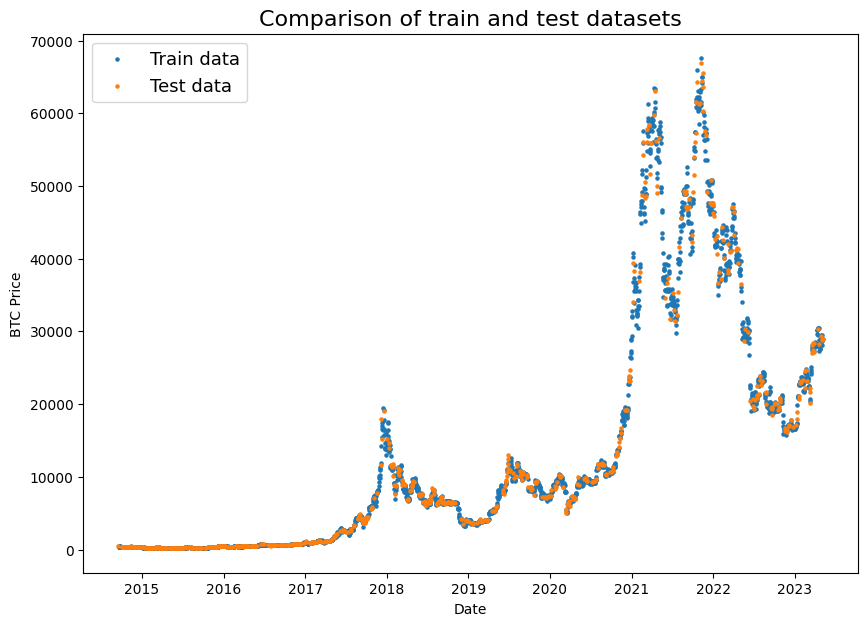

In [12]:
# Plotting wrong splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

### Create the train and test sets for time series (the proper way)

In [13]:
split_size = int(0.8 * len(prices)) # 80% test, 20% test; can be changed as needed

# Create proper splits
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2524, 631, 2524, 631)

Text(0.5, 1.0, 'Comparison of train and test datasets')

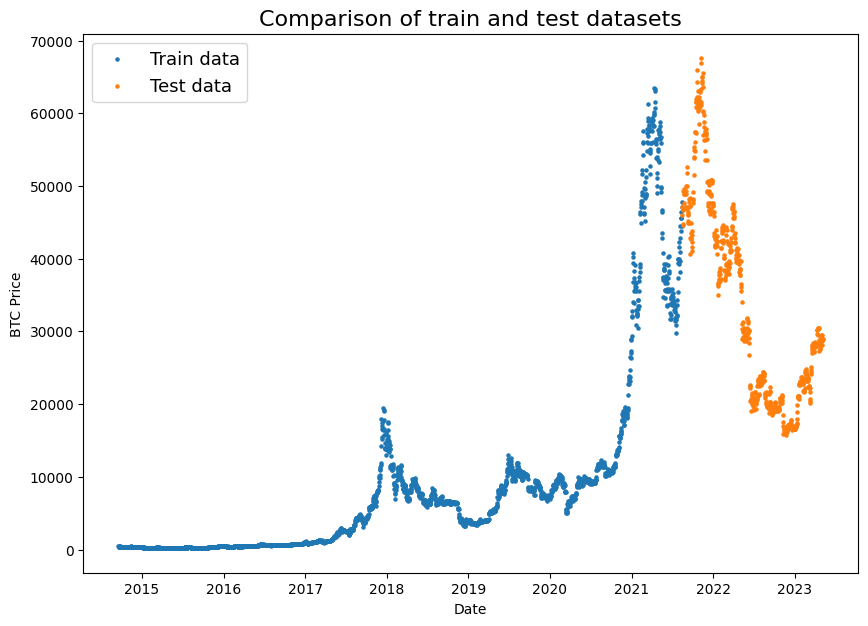

In [14]:
# Plot the correct splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

## Create a plotting function
As typing plotting code is tedious, it's time to functionize it.

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) againt values (a series of values across timesteps).

  Parameters:
  -----------
  timesteps : array of timestep values
  values : array of values across time
  format: style of plot, default "."
  start: where to start the plot (indexing from start of timesteps and values)
  end: same as above, but end
  label: label to show on plot about values, default None
  """
  # Plot the series
  #plt.figure(figsize=(10,7))
  plt.plot(timesteps[start:end],
           values[start:end],
           format,
           label=label)
  
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

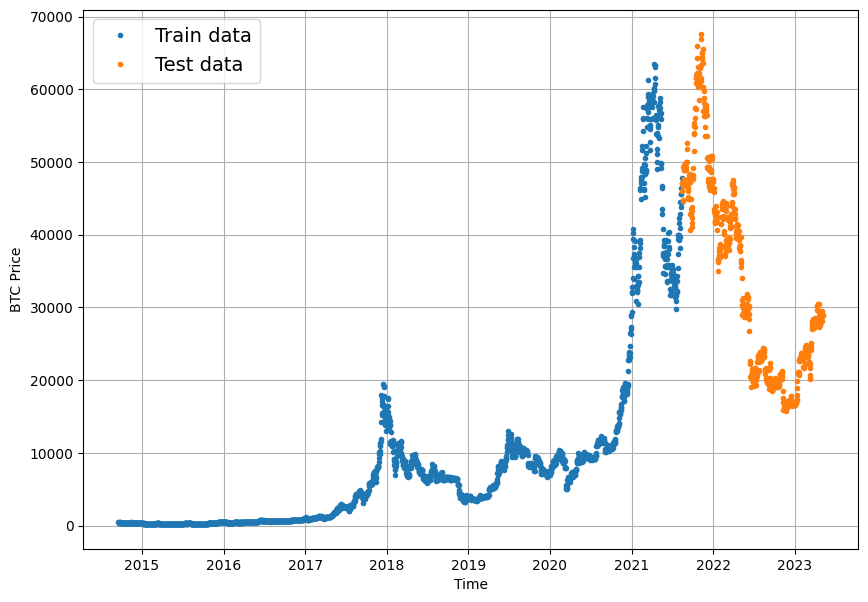

In [16]:
# Test the plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,
                 values=y_train,
                 label='Train data')
plot_time_series(timesteps=X_test,
                 values=y_test,
                 label='Test data')

## Modelling experiments

We've got some historical Bitcoin data. It's about time to note down the experiments we'd like to run.

Terms to be familiar with:
* *horizon* - steps into the future to predict
* *window size* - number of timestep to be used to predict the *horizon*

Experiments will be as follows:
0. Naive based model (baseline)
1. Dense model: horizon = 1, window = 7
2. Same as model 1: horizon = 1, window = 7
3. Same as model 1: horizon = 7, window = 30
4. Conv1D
5. LSTM
6. Same as model 1 (but with multivariate data)
7. N_BEATS algorithm
8. Ensemble (multiple models stacked together)
9. Future prediction model
10. Same as model 1 (but with turkey data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

> The prediction at timestep **t** (y-hat) is equal to the value at timestep **t-1** (previous timestep) - this is for a horizon of 1.

Lecture for this section:
https://otexts.com/fpp3/simple-methods.html

In [17]:
# Creating a naive forecast 
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([47047.003906, 46004.484375, 44695.359375, 44801.1875  ,
        46717.578125, 49339.175781, 48905.492188, 49321.652344,
        49546.148438, 47706.117188]),
 array([29473.787109, 29340.261719, 29248.488281, 29268.806641,
        28091.568359, 28680.537109, 29006.308594, 28847.710938,
        29534.384766, 28904.623047]))

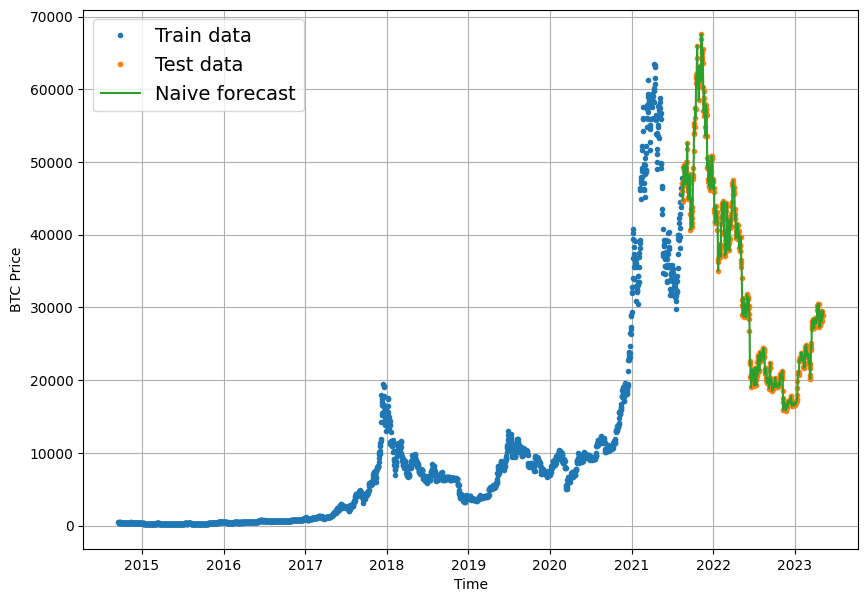

In [18]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

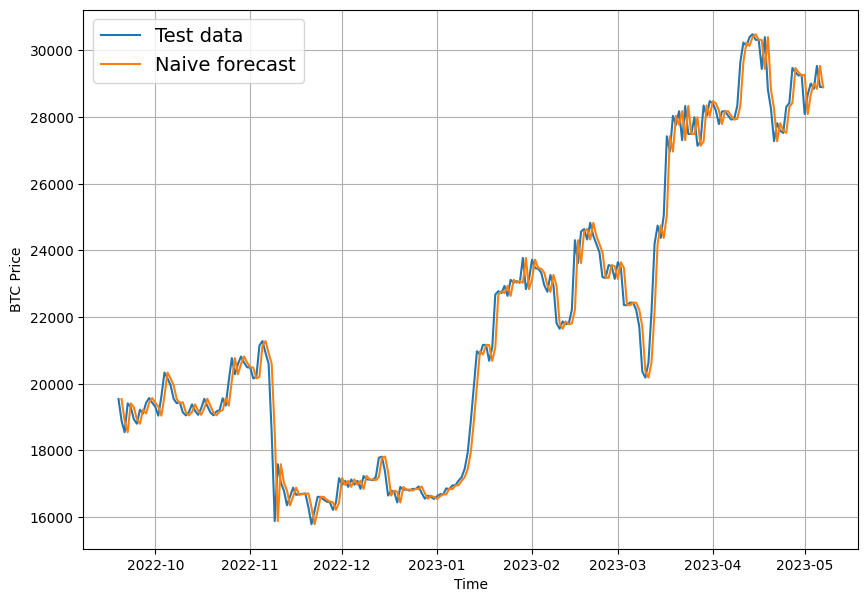

In [19]:
# Plot naive forecast - zoomed in version
plt.figure(figsize=(10, 7))
#plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, start=400, format='-', label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=400, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing? 

Predicting a number, so that means our problem is a **regression** problem. 

Because we're working on a regression problem, we're going to need some regression-like metrics.

A few common regression metrics, which also can be use for time series forecasting, are:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean sqaured error
* MAPE (sMAPE)- (scaled) mean absolute percentage error
* MASE - mean absolute scaled error

Main thing we're evaluating here is: **how do our model's forecast (`y_pred`) compare agains the actual values (`y_true`).**

### Creating MASE function

In [20]:
import tensorflow as tf

In [21]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE metric (assuming no seasonality of data).
  """

  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [22]:
mean_absolute_scaled_error(y_true=y_test[1:],
                           y_pred=naive_forecast).numpy()

1.0005690752533343

### Create a function for all of the metrics

In [23]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure data is float32 (default TensorFlow dtype)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)

  # Return a dictionary
  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [24]:
# Get the Naive forecast results
naive_results = evaluate_preds(y_true=y_test[1:], 
                               y_pred=naive_forecast)
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

In [25]:
# Average, min & max price
print(f"Average price: {tf.reduce_mean(y_test):.2f} USD") 
print(f"Minimum price: {tf.reduce_min(y_test):.2f} USD") 
print(f"Maximum price: {tf.reduce_max(y_test):.2f} USD")

Average price: 32882.82 USD
Minimum price: 15787.28 USD
Maximum price: 67566.83 USD


## Other model you can use for baselines and for actual forecasts
In this notebook, the main focus is on TensorFlow and building deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with:
https://github.com/mrdbourke/tensorflow-deep-learning#-10-time-series-fundamentals-and-milestone-project-3-bitpredict--exercises

## Format data part 2: Windowing our dataset
Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [26]:
# What we want to do with our BTC data
print(f"We want to use this: {btc_price[:7]} \nto predict this: {btc_price[7]}")

We want to use this: [457.334015, 424.440002, 394.79599, 408.903992, 398.821014, 402.152008, 435.790985] 
to predict this: 423.204987


In [27]:
# Setting up global variables for window and horizon size
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use past 7 days to make a prediction

In [28]:
# Create a function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.

  E.g.:
    if horizon = 1:
      Input = [0, 1, 2, 3, 4, 5, 6, 7]
      Output = ([0, 1, 2, 3, 4, 5, 6], [7])
  """

  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data. However, it only works on a small scale.

We need the way to do the above across our entire time series...

We could do this with Python `for()` loops, however for large time series that would be quite slow.

To speed things up, we'll leverage `NumPy`'s array indexing.

The function will:
1. Create a windows step of a specific window size.
2. Use `Numpy` indexing to create 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]...]
```
3. Uses the 2D array of multiple window step to index on a target series. 
4. Uses our `get_labelled_windows()` function to turn the window steps into windows with a specifide horizon.

> **Resource**: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [30]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows
  of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (plus horizon)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window step (minus 1 to account for indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  #print(window_indexes, window_indexes.shape)

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  #print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [31]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(3148, 3148)

In [32]:
# View the first 3 windows and labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987]
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005]
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988]


In [33]:
# View the last 3 windows
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [29340.261719 29248.488281 29268.806641 28091.568359 28680.537109
 29006.308594 28847.710938] -> Label: [29534.384766]
Window: [29248.488281 29268.806641 28091.568359 28680.537109 29006.308594
 28847.710938 29534.384766] -> Label: [28904.623047]
Window: [29268.806641 28091.568359 28680.537109 29006.308594 28847.710938
 29534.384766 28904.623047] -> Label: [28897.636719]


> **NOTE**: There's a function that does similar to the above in `tf.keras.preprocessing`. You can try to replicate the above using said function.

Resource: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [34]:
# Another approach - data not separated as for window and horizon
sequence = tf.keras.utils.timeseries_dataset_from_array(data=prices,
                                                        targets=None,
                                                        sequence_length=8,
                                                        sequence_stride=1,
                                                        sampling_rate=1,
                                                        batch_size=32)

for batch in sequence:
  print(batch)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  587.801025 592.103027]
 [578.289001 575.04303  587.778015 592.690002 591.054016 587.801025
  592.103027 589.119995]
 [575.04303  587.778015 592.690002 591.054016 587.801025 592.103027
  589.119995 587.559021]
 [587.778015 592.690002 591.054016 587.801025 592.103027 589.119995
  587.559021 585.588013]
 [592.690002 591.054016 587.801025 592.103027 589.119995 587.559021
  585.588013 570.473022]
 [591.054016 587.801025 592.103027 589.119995 587.559021 585.588013
  570.473022 567.23999 ]
 [587.801025 592.103027 589.119995 587.559021 585.588013 570.473022
  567.23999  577.439026]
 [592.103027 589.119995 587.559021 585.588013 570.473022 567.23999
  577.439026 573.216003]
 [589.119995 587.559021 585.588013 570.473022 567.23999  577.439026
  573.216003 574.317993]
 [587.559021 585.588013 570.473022 567.23999  577.439026 573.216003
  574.317993 575.630005]
 [585.588013 570.473022 567.23999  577.439026 573.216003 574.317993
  575.

In [35]:
# Another approach pt.2 - data separated as for window and horizon
input_data = prices[:-6]
targets = prices[7:]

sequence = tf.keras.utils.timeseries_dataset_from_array(data=input_data,
                                                        targets=targets,
                                                        sampling_rate=1,
                                                        sequence_length=7,
                                                        sequence_stride=1,
                                                        batch_size=32)


for batch in sequence:
  inputs, targets = batch
  #assert np.array_equal(inputs[0], prices[:7])
  #assert np.array_equal(targets[0], prices[7])
  #break
  print(inputs[1], targets[1])
print(prices[-10:])

tf.Tensor(
[424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987], shape=(7,), dtype=float64) tf.Tensor(411.574005, shape=(), dtype=float64)
tf.Tensor(
[382.845001 386.475006 383.15799  358.416992 358.345001 347.270996
 354.70401 ], shape=(7,), dtype=float64) tf.Tensor(352.989014, shape=(), dtype=float64)
tf.Tensor(
[350.847992 352.920013 367.572998 376.901001 375.347992 368.369995
 369.670013], shape=(7,), dtype=float64) tf.Tensor(376.446991, shape=(), dtype=float64)
tf.Tensor(
[334.571991 322.533997 319.007996 327.924011 315.863007 317.239014
 312.670013], shape=(7,), dtype=float64) tf.Tensor(310.737, shape=(), dtype=float64)
tf.Tensor(
[247.847    253.718002 273.472992 263.475006 233.914993 233.513
 226.425003], shape=(7,), dtype=float64) tf.Tensor(217.464005, shape=(), dtype=float64)
tf.Tensor(
[237.470001 236.425995 253.828003 254.263    260.201996 275.670013
 281.701996], shape=(7,), dtype=float64) tf.Tensor(273.09201, shape=(), dtype=float64)
tf.Tensor(


## Turning windows into training and test datasets

In [36]:
# Make the splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Split matching pairs of windows and labels into test and train
  datasets.
  """
  split_size = int(len(windows) * (1 - test_split)) # default to 80% train / 20% test

  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [37]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

In [38]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

In [39]:
# Chech to see if the train labels are the same (before and after the split)
np.array_equal(np.squeeze(train_labels[:-HORIZON]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate, `ModelCheckpoint` is quite useful. This way we can compare apples to apples.

More specifically, we want to compare each of our model's best perfoemance against the other model's best performance.

For example, if our model performs best on epoch 55, but the training is for 100 epochs, we'd like to load and evaluate the model on the best epoch there was.


In [40]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=1,
                                            save_best_only=True,
                                            monitor='val_loss')

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 units and ReLU activation funciton
* An output layer with a linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size = 128 (previously we've used 32)
* Epochs = 100

Why these values? They were picked out of experimenation.

* **Hyperparameters** = values a machine learning practitioner can adjust themselves.
* **Parameters** = values a model learns on its own.

In [41]:
import tensorflow as tf
from tensorflow.keras import layers

# Set the random seed
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear') # linear = no activation
], name='model_1_dense') # model name so we can save it

# 2. Compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# 3. Fit the model
history_model_1 = model_1.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              #batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
78/79 [============================>.] - ETA: 0s - loss: 1019.1429 - mae: 1019.1429 - mse: 7692813.0000
Epoch 1: val_loss improved from inf to 1901.78418, saving model to model_experiments/model_1_dense


79/79 [==============================] - 7s 21ms/step - loss: 1019.2852 - mae: 1019.2852 - mse: 7659602.0000 - val_loss: 1901.7842 - val_mae: 1901.7842 - val_mse: 6624683.0000
Epoch 2/100
69/79 [=========================>....] - ETA: 0s - loss: 510.3891 - mae: 510.3891 - mse: 1488095.2500
Epoch 2: val_loss improved from 1901.78418 to 1780.91602, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 15ms/step - loss: 505.1623 - mae: 505.1623 - mse: 1415327.6250 - val_loss: 1780.9160 - val_mae: 1780.9160 - val_mse: 5690263.0000
Epoch 3/100
76/79 [===========================>..] - ETA: 0s - loss: 449.1670 - mae: 449.1670 - mse: 1062428.7500
Epoch 3: val_loss improved from 1780.91602 to 1266.51587, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 13ms/step - loss: 452.9447 - mae: 452.9447 - mse: 1071302.2500 - val_loss: 1266.5159 - val_mae: 1266.5159 - val_mse: 3111507.7500
Epoch 4/100
70/79 [=========================>....] - ETA: 0s - loss: 382.5874 - mae: 382.5874 - mse: 798331.5000
Epoch 4: val_loss did not improve from 1266.51587
79/79 [==============================] - 0s 4ms/step - loss: 400.8781 - mae: 400.8781 - mse: 912796.8750 - val_loss: 1605.5658 - val_mae: 1605.5658 - val_mse: 4571916.5000
Epoch 5/100
78/79 [============================>.] - ETA: 0s - loss: 401.8435 - mae: 401.8435 - mse: 853008.3750
Epoch 5: val_loss improved from 1266.51587 to 972.82721, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 401.8698 - mae: 401.8698 - mse: 856158.5625 - val_loss: 972.8272 - val_mae: 972.8272 - val_mse: 2007238.8750
Epoch 6/100
72/79 [==========================>...] - ETA: 0s - loss: 361.8314 - mae: 361.8314 - mse: 789488.7500
Epoch 6: val_loss did not improve from 972.82721
79/79 [==============================] - 0s 4ms/step - loss: 364.0782 - mae: 364.0782 - mse: 779285.5625 - val_loss: 1046.5378 - val_mae: 1046.5378 - val_mse: 2294960.2500
Epoch 7/100
66/79 [========================>.....] - ETA: 0s - loss: 358.0759 - mae: 358.0759 - mse: 723434.2500
Epoch 7: val_loss did not improve from 972.82721
79/79 [==============================] - 0s 4ms/step - loss: 347.0120 - mae: 347.0120 - mse: 668379.6250 - val_loss: 1536.9268 - val_mae: 1536.9268 - val_mse: 4056935.5000
Epoch 8/100
75/79 [===========================>..] - ETA: 0s - loss: 327.6110 - mae: 327.6110 - mse: 615398.3125
Epoch 8: val_loss did not improve from 972.82721

79/79 [==============================] - 1s 10ms/step - loss: 356.3119 - mae: 356.3119 - mse: 676278.3750 - val_loss: 882.5784 - val_mae: 882.5784 - val_mse: 1646203.6250
Epoch 10/100
65/79 [=======================>......] - ETA: 0s - loss: 312.3562 - mae: 312.3562 - mse: 588002.1250
Epoch 10: val_loss improved from 882.57837 to 860.03741, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 315.9418 - mae: 315.9418 - mse: 591183.6250 - val_loss: 860.0374 - val_mae: 860.0374 - val_mse: 1622042.8750
Epoch 11/100
68/79 [========================>.....] - ETA: 0s - loss: 298.1783 - mae: 298.1783 - mse: 516003.4688
Epoch 11: val_loss improved from 860.03741 to 850.65814, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 302.4783 - mae: 302.4783 - mse: 527143.1875 - val_loss: 850.6581 - val_mae: 850.6581 - val_mse: 1597370.1250
Epoch 12/100
69/79 [=========================>....] - ETA: 0s - loss: 311.0493 - mae: 311.0493 - mse: 547273.4375
Epoch 12: val_loss did not improve from 850.65814
79/79 [==============================] - 0s 4ms/step - loss: 311.6183 - mae: 311.6183 - mse: 560264.9375 - val_loss: 912.6369 - val_mae: 912.6369 - val_mse: 1803548.5000
Epoch 13/100
68/79 [========================>.....] - ETA: 0s - loss: 294.6466 - mae: 294.6466 - mse: 496810.4062
Epoch 13: val_loss did not improve from 850.65814
79/79 [==============================] - 0s 4ms/step - loss: 290.4531 - mae: 290.4531 - mse: 497817.8125 - val_loss: 997.3060 - val_mae: 997.3060 - val_mse: 2052915.6250
Epoch 14/100
66/79 [========================>.....] - ETA: 0s - loss: 291.7621 - mae: 291.7621 - mse: 489311.4062
Epoch 14: val_loss did not improve from 850.658

79/79 [==============================] - 1s 10ms/step - loss: 318.7913 - mae: 318.7913 - mse: 587972.1875 - val_loss: 806.9672 - val_mae: 806.9672 - val_mse: 1474741.5000
Epoch 21/100
66/79 [========================>.....] - ETA: 0s - loss: 279.6583 - mae: 279.6583 - mse: 492757.7188
Epoch 21: val_loss improved from 806.96716 to 805.72699, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 13ms/step - loss: 286.0792 - mae: 286.0792 - mse: 488844.9688 - val_loss: 805.7270 - val_mae: 805.7270 - val_mse: 1467697.1250
Epoch 22/100
65/79 [=======================>......] - ETA: 0s - loss: 290.4405 - mae: 290.4405 - mse: 507174.3125
Epoch 22: val_loss did not improve from 805.72699
79/79 [==============================] - 0s 4ms/step - loss: 295.8666 - mae: 295.8666 - mse: 514922.6562 - val_loss: 813.6511 - val_mae: 813.6511 - val_mse: 1505619.1250
Epoch 23/100
72/79 [==========================>...] - ETA: 0s - loss: 283.4597 - mae: 283.4597 - mse: 477980.7812
Epoch 23: val_loss did not improve from 805.72699
79/79 [==============================] - 0s 4ms/step - loss: 282.9931 - mae: 282.9931 - mse: 468111.7188 - val_loss: 1077.4573 - val_mae: 1077.4573 - val_mse: 2128692.2500
Epoch 24/100
71/79 [=========================>....] - ETA: 0s - loss: 275.9999 - mae: 275.9999 - mse: 469691.9062
Epoch 24: val_loss did not improve from 805.7

79/79 [==============================] - 2s 25ms/step - loss: 298.0779 - mae: 298.0779 - mse: 530046.2500 - val_loss: 796.8505 - val_mae: 796.8505 - val_mse: 1443438.3750
Epoch 30/100
76/79 [===========================>..] - ETA: 0s - loss: 287.4011 - mae: 287.4011 - mse: 479601.4062
Epoch 30: val_loss did not improve from 796.85052
79/79 [==============================] - 1s 7ms/step - loss: 287.9446 - mae: 287.9446 - mse: 479673.6875 - val_loss: 907.1847 - val_mae: 907.1847 - val_mse: 1666057.7500
Epoch 31/100
71/79 [=========================>....] - ETA: 0s - loss: 289.3282 - mae: 289.3282 - mse: 490072.2812
Epoch 31: val_loss did not improve from 796.85052
79/79 [==============================] - 1s 8ms/step - loss: 286.1927 - mae: 286.1927 - mse: 478697.0625 - val_loss: 1000.6539 - val_mae: 1000.6539 - val_mse: 2003391.6250
Epoch 32/100
77/79 [============================>.] - ETA: 0s - loss: 274.6807 - mae: 274.6807 - mse: 455473.6562
Epoch 32: val_loss improved from 796.85052 to

79/79 [==============================] - 1s 17ms/step - loss: 276.6388 - mae: 276.6388 - mse: 458089.2812 - val_loss: 790.5665 - val_mae: 790.5665 - val_mse: 1446192.5000
Epoch 33/100
66/79 [========================>.....] - ETA: 0s - loss: 288.1125 - mae: 288.1125 - mse: 475000.4062
Epoch 33: val_loss did not improve from 790.56653
79/79 [==============================] - 0s 4ms/step - loss: 291.5776 - mae: 291.5776 - mse: 494079.7500 - val_loss: 974.6715 - val_mae: 974.6715 - val_mse: 1836558.2500
Epoch 34/100
68/79 [========================>.....] - ETA: 0s - loss: 305.1676 - mae: 305.1676 - mse: 536048.3750
Epoch 34: val_loss did not improve from 790.56653
79/79 [==============================] - 0s 4ms/step - loss: 306.7832 - mae: 306.7832 - mse: 549087.8125 - val_loss: 943.7720 - val_mae: 943.7720 - val_mse: 1756039.5000
Epoch 35/100
68/79 [========================>.....] - ETA: 0s - loss: 276.5703 - mae: 276.5703 - mse: 496561.5938
Epoch 35: val_loss did not improve from 790.566

79/79 [==============================] - 1s 10ms/step - loss: 314.7756 - mae: 314.7756 - mse: 551791.0000 - val_loss: 777.8505 - val_mae: 777.8505 - val_mse: 1414718.5000
Epoch 50/100
69/79 [=========================>....] - ETA: 0s - loss: 279.3174 - mae: 279.3174 - mse: 472572.6875
Epoch 50: val_loss did not improve from 777.85052
79/79 [==============================] - 0s 4ms/step - loss: 284.3303 - mae: 284.3303 - mse: 482235.2188 - val_loss: 917.8233 - val_mae: 917.8233 - val_mse: 1771708.7500
Epoch 51/100
65/79 [=======================>......] - ETA: 0s - loss: 313.8879 - mae: 313.8879 - mse: 538421.9375
Epoch 51: val_loss did not improve from 777.85052
79/79 [==============================] - 0s 4ms/step - loss: 324.9935 - mae: 324.9935 - mse: 577869.7500 - val_loss: 818.5521 - val_mae: 818.5521 - val_mse: 1477669.7500
Epoch 52/100
79/79 [==============================] - ETA: 0s - loss: 295.2707 - mae: 295.2707 - mse: 515650.9375
Epoch 52: val_loss did not improve from 777.850

79/79 [==============================] - 1s 14ms/step - loss: 296.8463 - mae: 296.8463 - mse: 512874.1562 - val_loss: 776.2634 - val_mae: 776.2634 - val_mse: 1414486.5000
Epoch 58/100
74/79 [===========================>..] - ETA: 0s - loss: 282.3654 - mae: 282.3654 - mse: 508075.5625
Epoch 58: val_loss did not improve from 776.26343
79/79 [==============================] - 1s 6ms/step - loss: 280.5903 - mae: 280.5903 - mse: 495319.0938 - val_loss: 967.8996 - val_mae: 967.8996 - val_mse: 1906947.0000
Epoch 59/100
69/79 [=========================>....] - ETA: 0s - loss: 273.5463 - mae: 273.5463 - mse: 472063.7500
Epoch 59: val_loss did not improve from 776.26343
79/79 [==============================] - 1s 7ms/step - loss: 280.7861 - mae: 280.7861 - mse: 496161.8125 - val_loss: 850.9042 - val_mae: 850.9042 - val_mse: 1538526.1250
Epoch 60/100
68/79 [========================>.....] - ETA: 0s - loss: 274.4238 - mae: 274.4238 - mse: 445228.3125
Epoch 60: val_loss did not improve from 776.263

79/79 [==============================] - 1s 10ms/step - loss: 280.0659 - mae: 280.0659 - mse: 485773.5625 - val_loss: 776.1907 - val_mae: 776.1907 - val_mse: 1410778.5000
Epoch 67/100
67/79 [========================>.....] - ETA: 0s - loss: 277.3537 - mae: 277.3537 - mse: 464653.2188
Epoch 67: val_loss did not improve from 776.19073
79/79 [==============================] - 0s 4ms/step - loss: 277.1701 - mae: 277.1701 - mse: 463081.5312 - val_loss: 1209.2937 - val_mae: 1209.2937 - val_mse: 2524183.0000
Epoch 68/100
65/79 [=======================>......] - ETA: 0s - loss: 336.8008 - mae: 336.8008 - mse: 605790.3125
Epoch 68: val_loss did not improve from 776.19073
79/79 [==============================] - 0s 4ms/step - loss: 337.2622 - mae: 337.2622 - mse: 600181.9375 - val_loss: 805.6932 - val_mae: 805.6932 - val_mse: 1491086.1250
Epoch 69/100
69/79 [=========================>....] - ETA: 0s - loss: 282.5085 - mae: 282.5085 - mse: 491880.0000
Epoch 69: val_loss did not improve from 776.1

79/79 [==============================] - 1s 10ms/step - loss: 277.0525 - mae: 277.0525 - mse: 470793.3125 - val_loss: 775.7122 - val_mae: 775.7122 - val_mse: 1415018.0000
Epoch 72/100
64/79 [=======================>......] - ETA: 0s - loss: 276.5476 - mae: 276.5476 - mse: 450902.2812
Epoch 72: val_loss did not improve from 775.71222
79/79 [==============================] - 0s 4ms/step - loss: 277.9252 - mae: 277.9252 - mse: 454688.2188 - val_loss: 842.7632 - val_mae: 842.7632 - val_mse: 1578240.1250
Epoch 73/100
64/79 [=======================>......] - ETA: 0s - loss: 283.8856 - mae: 283.8856 - mse: 502898.3125
Epoch 73: val_loss did not improve from 775.71222
79/79 [==============================] - 0s 4ms/step - loss: 276.6212 - mae: 276.6212 - mse: 464501.2812 - val_loss: 847.7094 - val_mae: 847.7094 - val_mse: 1587461.2500
Epoch 74/100
79/79 [==============================] - ETA: 0s - loss: 276.4140 - mae: 276.4140 - mse: 455772.6562
Epoch 74: val_loss did not improve from 775.712

79/79 [==============================] - 1s 13ms/step - loss: 300.2870 - mae: 300.2870 - mse: 514813.7188 - val_loss: 775.2205 - val_mae: 775.2205 - val_mse: 1414020.7500
Epoch 87/100
70/79 [=========================>....] - ETA: 0s - loss: 282.6026 - mae: 282.6026 - mse: 451074.2188
Epoch 87: val_loss did not improve from 775.22052
79/79 [==============================] - 0s 6ms/step - loss: 297.4318 - mae: 297.4318 - mse: 527215.1250 - val_loss: 844.9583 - val_mae: 844.9583 - val_mse: 1531957.2500
Epoch 88/100
76/79 [===========================>..] - ETA: 0s - loss: 340.6671 - mae: 340.6671 - mse: 651941.2500
Epoch 88: val_loss did not improve from 775.22052
79/79 [==============================] - 0s 6ms/step - loss: 336.7002 - mae: 336.7002 - mse: 636490.2500 - val_loss: 1034.4855 - val_mae: 1034.4855 - val_mse: 2002791.6250
Epoch 89/100
78/79 [============================>.] - ETA: 0s - loss: 272.3797 - mae: 272.3797 - mse: 446002.8750
Epoch 89: val_loss did not improve from 775.2

In [42]:
# Evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 903.6870 - mae: 903.6870 - mse: 1659908.1250


[903.68701171875, 903.68701171875, 1659908.125]

In [43]:
# Load in the saved, best performat model
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 775.2205 - mae: 775.2205 - mse: 1414020.7500


[775.2205200195312, 775.2205200195312, 1414020.75]

### Make forecasts with a model (on the test dataset)

To make 'forecasts' on the test dataset, let's write a function to:
1. Takes in a trained model
2. Takes in some input data
3. Passes the input to the `predict()` method
4. Returns the predictions

In [44]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # 1D array of preds as output

In [45]:
# Make predictions using model_1
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10], len(model_1_preds)

20/20 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([46868.62 , 46248.367, 44650.742, 44747.98 , 46366.137, 48985.145,
        48979.387, 49261.902, 49604.613, 47859.4  ], dtype=float32)>,
 630)

In [46]:
# Shapes had to be changes 
test_labels.shape, model_1_preds.shape

((630, 1), TensorShape([630]))

In [47]:
# Evaluate our preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 775.2205,
 'mse': 1414020.9,
 'rmse': 1189.1261,
 'mape': 2.28088,
 'mase': 1.0101975}

In [48]:
# Naive results
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

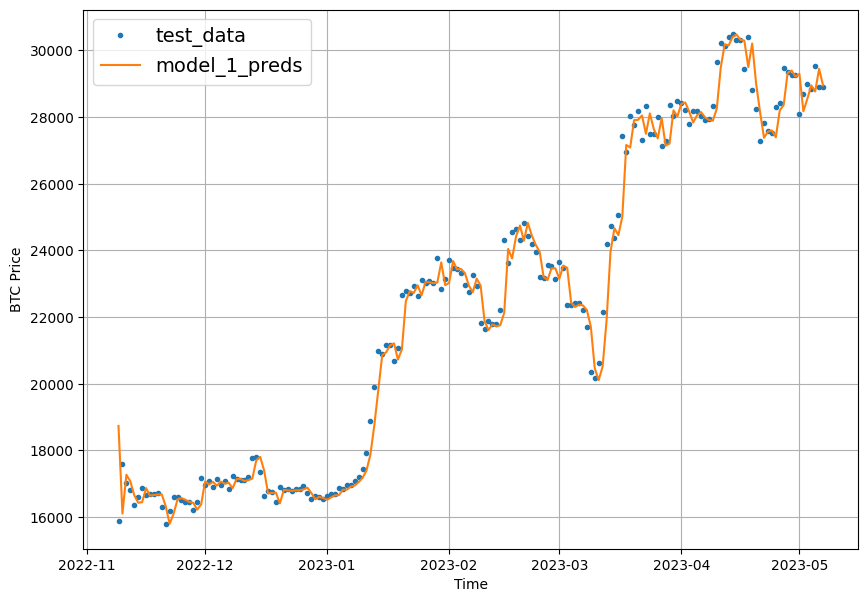

In [49]:
# Let's plot model_1 predictions 
offset=450
plt.figure(figsize=(10,7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_1_preds, 
                 format="-",
                 start=offset, 
                 label='model_1_preds')

## Model 2: Dense (window = 30, horizon = 1)

In [50]:
# Update global variables
HORIZON = 1
WINDOW_SIZE = 30

In [51]:
# Make window data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3125, 3125)

In [52]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2500, 625, 2500, 625)

In [53]:
train_windows[:3], train_labels[:3]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005, 404.424988, 399.519989, 377.181   ,
         375.46701 , 386.944   ,

In [54]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

# Compile the model
model_2.compile(loss='mae',
                optimizer='adam',
                metrics=['mse', 'mae'])

# Fit the model
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


Epoch 1: val_loss improved from inf to 6040.73975, saving model to model_experiments/model_2_dense



Epoch 2: val_loss improved from 6040.73975 to 3537.61279, saving model to model_experiments/model_2_dense



Epoch 3: val_loss improved from 3537.61279 to 3417.25488, saving model to model_experiments/model_2_dense



Epoch 4: val_loss improved from 3417.25488 to 1966.10876, saving model to model_experiments/model_2_dense



Epoch 5: val_loss did not improve from 1966.10876

Epoch 6: val_loss improved from 1966.10876 to 1437.53809, saving model to model_experiments/model_2_dense



Epoch 7: val_loss did not improve from 1437.53809

Epoch 8: val_loss did not improve from 1437.53809

Epoch 9: val_loss did not improve from 1437.53809

Epoch 10: val_loss did not improve from 1437.53809

Epoch 11: val_loss did not improve from 1437.53809

Epoch 12: val_loss improved from 1437.53809 to 1307.90515, saving model to model_experiments/model_2_dense



Epoch 13: val_loss improved from 1307.90515 to 1157.72656, saving model to model_experiments/model_2_dense



Epoch 14: val_loss did not improve from 1157.72656

Epoch 15: val_loss improved from 1157.72656 to 1147.57849, saving model to model_experiments/model_2_dense



Epoch 16: val_loss did not improve from 1147.57849

Epoch 17: val_loss did not improve from 1147.57849

Epoch 18: val_loss improved from 1147.57849 to 1116.15344, saving model to model_experiments/model_2_dense



Epoch 19: val_loss did not improve from 1116.15344

Epoch 20: val_loss did not improve from 1116.15344

Epoch 21: val_loss improved from 1116.15344 to 1038.31824, saving model to model_experiments/model_2_dense



Epoch 22: val_loss did not improve from 1038.31824

Epoch 23: val_loss did not improve from 1038.31824

Epoch 24: val_loss did not improve from 1038.31824

Epoch 25: val_loss did not improve from 1038.31824

Epoch 26: val_loss did not improve from 1038.31824

Epoch 27: val_loss did not improve from 1038.31824

Epoch 28: val_loss did not improve from 1038.31824

Epoch 29: val_loss did not improve from 1038.31824

Epoch 30: val_loss did not improve from 1038.31824

Epoch 31: val_loss did not improve from 1038.31824

Epoch 32: val_loss did not improve from 1038.31824

Epoch 33: val_loss improved from 1038.31824 to 1003.94440, saving model to model_experiments/model_2_dense



Epoch 34: val_loss did not improve from 1003.94440

Epoch 35: val_loss improved from 1003.94440 to 946.76251, saving model to model_experiments/model_2_dense



Epoch 36: val_loss did not improve from 946.76251

Epoch 37: val_loss did not improve from 946.76251

Epoch 38: val_loss did not improve from 946.76251

Epoch 39: val_loss improved from 946.76251 to 928.88531, saving model to model_experiments/model_2_dense



Epoch 40: val_loss did not improve from 928.88531

Epoch 41: val_loss did not improve from 928.88531

Epoch 42: val_loss did not improve from 928.88531

Epoch 43: val_loss improved from 928.88531 to 917.31409, saving model to model_experiments/model_2_dense



Epoch 44: val_loss did not improve from 917.31409

Epoch 45: val_loss improved from 917.31409 to 913.82629, saving model to model_experiments/model_2_dense



Epoch 46: val_loss did not improve from 913.82629

Epoch 47: val_loss did not improve from 913.82629

Epoch 48: val_loss did not improve from 913.82629

Epoch 49: val_loss did not improve from 913.82629

Epoch 50: val_loss improved from 913.82629 to 892.05981, saving model to model_experiments/model_2_dense



Epoch 51: val_loss did not improve from 892.05981

Epoch 52: val_loss did not improve from 892.05981

Epoch 53: val_loss did not improve from 892.05981

Epoch 54: val_loss did not improve from 892.05981

Epoch 55: val_loss improved from 892.05981 to 877.90338, saving model to model_experiments/model_2_dense



Epoch 56: val_loss did not improve from 877.90338

Epoch 57: val_loss did not improve from 877.90338

Epoch 58: val_loss did not improve from 877.90338

Epoch 59: val_loss did not improve from 877.90338

Epoch 60: val_loss did not improve from 877.90338

Epoch 61: val_loss did not improve from 877.90338

Epoch 62: val_loss did not improve from 877.90338

Epoch 63: val_loss did not improve from 877.90338

Epoch 64: val_loss did not improve from 877.90338

Epoch 65: val_loss did not improve from 877.90338

Epoch 66: val_loss improved from 877.90338 to 864.17340, saving model to model_experiments/model_2_dense



Epoch 67: val_loss did not improve from 864.17340

Epoch 68: val_loss did not improve from 864.17340

Epoch 69: val_loss did not improve from 864.17340

Epoch 70: val_loss did not improve from 864.17340

Epoch 71: val_loss did not improve from 864.17340

Epoch 72: val_loss did not improve from 864.17340

Epoch 73: val_loss did not improve from 864.17340

Epoch 74: val_loss did not improve from 864.17340

Epoch 75: val_loss improved from 864.17340 to 846.28320, saving model to model_experiments/model_2_dense



Epoch 76: val_loss did not improve from 846.28320

Epoch 77: val_loss improved from 846.28320 to 843.40308, saving model to model_experiments/model_2_dense



Epoch 78: val_loss did not improve from 843.40308

Epoch 79: val_loss did not improve from 843.40308

Epoch 80: val_loss did not improve from 843.40308

Epoch 81: val_loss did not improve from 843.40308

Epoch 82: val_loss improved from 843.40308 to 838.46698, saving model to model_experiments/model_2_dense



Epoch 83: val_loss did not improve from 838.46698

Epoch 84: val_loss did not improve from 838.46698

Epoch 85: val_loss did not improve from 838.46698

Epoch 86: val_loss did not improve from 838.46698

Epoch 87: val_loss did not improve from 838.46698

Epoch 88: val_loss did not improve from 838.46698

Epoch 89: val_loss did not improve from 838.46698

Epoch 90: val_loss did not improve from 838.46698

Epoch 91: val_loss did not improve from 838.46698

Epoch 92: val_loss did not improve from 838.46698

Epoch 93: val_loss did not improve from 838.46698

Epoch 94: val_loss did not improve from 838.46698

Epoch 95: val_loss did not improve from 838.46698

Epoch 96: val_loss improved from 838.46698 to 835.15509, saving model to model_experiments/model_2_dense



Epoch 97: val_loss did not improve from 835.15509

Epoch 98: val_loss did not improve from 835.15509

Epoch 99: val_loss did not improve from 835.15509

Epoch 100: val_loss did not improve from 835.15509


In [55]:
# Evaluate model_2 on test data
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 8ms/step - loss: 985.4324 - mse: 1890051.5000 - mae: 985.4324


[985.432373046875, 1890051.5, 985.432373046875]

In [56]:
# Load in the best performant model_2
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 1s 7ms/step - loss: 835.1551 - mse: 1582490.1250 - mae: 835.1551


[835.1550903320312, 1582490.125, 835.1550903320312]

In [57]:
# Get the forecast predicions
model_2_preds = make_preds(model_2, test_windows)

20/20 [==============================] - 0s 5ms/step


In [58]:
# Evaluate results for model_2 prediction
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 835.15515,
 'mse': 1582490.0,
 'rmse': 1257.9706,
 'mape': 2.4846172,
 'mase': 1.0941244}

In [59]:
model_1_results

{'mae': 775.2205,
 'mse': 1414020.9,
 'rmse': 1189.1261,
 'mape': 2.28088,
 'mase': 1.0101975}

In [60]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

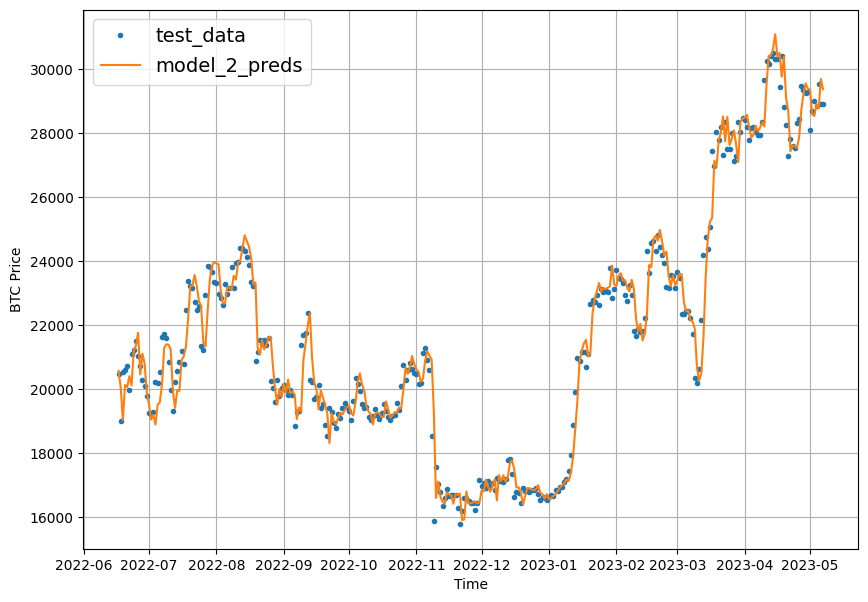

In [61]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_2_preds,
                 start=offset,
                 format="-",
                 label='model_2_preds')

## Model 3: Dense (window = 30, horizon = 7)

In [62]:
# Update global variables
HORIZON = 7
WINDOW_SIZE = 30

In [63]:
# Create new windows
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(3119, 3119)

In [64]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2495, 624, 2495, 624)

In [65]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile the model
model_3.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

# Fit the model
model_3.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_3.name)])


Epoch 1: val_loss improved from inf to 3951.20435, saving model to model_experiments/model_3_dense



Epoch 2: val_loss improved from 3951.20435 to 2393.51904, saving model to model_experiments/model_3_dense



Epoch 3: val_loss improved from 2393.51904 to 2186.99170, saving model to model_experiments/model_3_dense



Epoch 4: val_loss did not improve from 2186.99170

Epoch 5: val_loss did not improve from 2186.99170

Epoch 6: val_loss improved from 2186.99170 to 2000.10901, saving model to model_experiments/model_3_dense



Epoch 7: val_loss did not improve from 2000.10901

Epoch 8: val_loss did not improve from 2000.10901

Epoch 9: val_loss improved from 2000.10901 to 1891.75244, saving model to model_experiments/model_3_dense



Epoch 10: val_loss did not improve from 1891.75244

Epoch 11: val_loss did not improve from 1891.75244

Epoch 12: val_loss improved from 1891.75244 to 1872.46411, saving model to model_experiments/model_3_dense



Epoch 13: val_loss did not improve from 1872.46411

Epoch 14: val_loss did not improve from 1872.46411

Epoch 15: val_loss improved from 1872.46411 to 1818.77661, saving model to model_experiments/model_3_dense



Epoch 16: val_loss did not improve from 1818.77661

Epoch 17: val_loss improved from 1818.77661 to 1781.15869, saving model to model_experiments/model_3_dense



Epoch 18: val_loss improved from 1781.15869 to 1723.50586, saving model to model_experiments/model_3_dense



Epoch 19: val_loss did not improve from 1723.50586

Epoch 20: val_loss did not improve from 1723.50586

Epoch 21: val_loss did not improve from 1723.50586

Epoch 22: val_loss did not improve from 1723.50586

Epoch 23: val_loss did not improve from 1723.50586

Epoch 24: val_loss did not improve from 1723.50586

Epoch 25: val_loss did not improve from 1723.50586

Epoch 26: val_loss did not improve from 1723.50586

Epoch 27: val_loss did not improve from 1723.50586

Epoch 28: val_loss did not improve from 1723.50586

Epoch 29: val_loss did not improve from 1723.50586

Epoch 30: val_loss improved from 1723.50586 to 1699.17468, saving model to model_experiments/model_3_dense



Epoch 31: val_loss did not improve from 1699.17468

Epoch 32: val_loss did not improve from 1699.17468

Epoch 33: val_loss did not improve from 1699.17468

Epoch 34: val_loss did not improve from 1699.17468

Epoch 35: val_loss improved from 1699.17468 to 1681.14368, saving model to model_experiments/model_3_dense



Epoch 36: val_loss improved from 1681.14368 to 1654.76208, saving model to model_experiments/model_3_dense



Epoch 37: val_loss did not improve from 1654.76208

Epoch 38: val_loss did not improve from 1654.76208

Epoch 39: val_loss did not improve from 1654.76208

Epoch 40: val_loss did not improve from 1654.76208

Epoch 41: val_loss did not improve from 1654.76208

Epoch 42: val_loss did not improve from 1654.76208

Epoch 43: val_loss did not improve from 1654.76208

Epoch 44: val_loss did not improve from 1654.76208

Epoch 45: val_loss did not improve from 1654.76208

Epoch 46: val_loss did not improve from 1654.76208

Epoch 47: val_loss did not improve from 1654.76208

Epoch 48: val_loss did not improve from 1654.76208

Epoch 49: val_loss did not improve from 1654.76208

Epoch 50: val_loss did not improve from 1654.76208

Epoch 51: val_loss did not improve from 1654.76208

Epoch 52: val_loss did not improve from 1654.76208

Epoch 53: val_loss did not improve from 1654.76208

Epoch 54: val_loss did not improve from 1654.76208

Epoch 55: val_loss did not improve from 1654.76208

Epoch 56: v


Epoch 61: val_loss did not improve from 1634.71802

Epoch 62: val_loss did not improve from 1634.71802

Epoch 63: val_loss did not improve from 1634.71802

Epoch 64: val_loss did not improve from 1634.71802

Epoch 65: val_loss did not improve from 1634.71802

Epoch 66: val_loss did not improve from 1634.71802

Epoch 67: val_loss did not improve from 1634.71802

Epoch 68: val_loss did not improve from 1634.71802

Epoch 69: val_loss did not improve from 1634.71802

Epoch 70: val_loss did not improve from 1634.71802

Epoch 71: val_loss did not improve from 1634.71802

Epoch 72: val_loss did not improve from 1634.71802

Epoch 73: val_loss did not improve from 1634.71802

Epoch 74: val_loss did not improve from 1634.71802

Epoch 75: val_loss improved from 1634.71802 to 1630.14551, saving model to model_experiments/model_3_dense



Epoch 76: val_loss did not improve from 1630.14551

Epoch 77: val_loss did not improve from 1630.14551

Epoch 78: val_loss did not improve from 1630.14551

Epoch 79: val_loss did not improve from 1630.14551

Epoch 80: val_loss did not improve from 1630.14551

Epoch 81: val_loss did not improve from 1630.14551

Epoch 82: val_loss improved from 1630.14551 to 1607.93945, saving model to model_experiments/model_3_dense



Epoch 83: val_loss did not improve from 1607.93945

Epoch 84: val_loss did not improve from 1607.93945

Epoch 85: val_loss did not improve from 1607.93945

Epoch 86: val_loss did not improve from 1607.93945

Epoch 87: val_loss did not improve from 1607.93945

Epoch 88: val_loss did not improve from 1607.93945

Epoch 89: val_loss did not improve from 1607.93945

Epoch 90: val_loss did not improve from 1607.93945

Epoch 91: val_loss did not improve from 1607.93945

Epoch 92: val_loss did not improve from 1607.93945

Epoch 93: val_loss did not improve from 1607.93945

Epoch 94: val_loss did not improve from 1607.93945

Epoch 95: val_loss did not improve from 1607.93945

Epoch 96: val_loss did not improve from 1607.93945

Epoch 97: val_loss did not improve from 1607.93945

Epoch 98: val_loss did not improve from 1607.93945

Epoch 99: val_loss did not improve from 1607.93945

Epoch 100: val_loss did not improve from 1607.93945


In [66]:
# Evaluate the model
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1700.7075 - mae: 1700.7075 - mse: 5992886.5000


[1700.70751953125, 1700.70751953125, 5992886.5]

In [67]:
# Evaluate the best epoch
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense')
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 1607.9395 - mae: 1607.9395 - mse: 5645820.0000


[1607.939453125, 1607.939453125, 5645820.0]

In [68]:
# Make the predictions
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[46850.703, 47914.586, 47824.86 , 47309.094, 47301.406, 47545.05 ,
        47019.3  ],
       [46063.816, 46744.465, 47298.56 , 46769.453, 46551.918, 46797.285,
        46464.55 ],
       [44730.17 , 45415.25 , 46041.52 , 45814.555, 45840.63 , 45595.535,
        45978.39 ],
       [44061.348, 44612.387, 45229.656, 45236.74 , 45510.53 , 45731.473,
        45528.254],
       [45626.227, 45958.586, 46438.84 , 46622.473, 46891.816, 47097.434,
        47271.16 ]], dtype=float32)>

In [69]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([1911.5994  , 2060.2825  , 2417.3286  , 3512.3667  , 2210.4202  ,
         925.2411  , 1799.774   , 2483.8386  , 2592.8186  ,  921.47156 ,
         960.3867  , 1471.5475  , 1075.6183  , 1087.1189  , 1218.1747  ,
        1899.3438  , 2268.717   , 2179.5916  , 2651.0173  , 3228.1858  ,
        4119.8687  , 5944.0493  , 7371.3403  , 2735.7808  , 1034.0826  ,
         975.74445 , 2170.193   , 2774.8433  , 1306.1736  , 1853.7773  ,
        2132.7444  , 2878.284   , 3359.2214  , 3620.1172  , 4657.247   ,
        4564.621   , 1246.8119  , 1957.582   ,  893.02344 , 1222.4095  ,
        1625.0865  , 2202.0925  , 2580.1177  , 3302.1428  , 5626.4526  ,
        7984.6294  , 7698.947   , 4624.249   , 5315.6875  , 5582.617   ,
        5578.4014  , 4480.6885  , 1772.1044  , 1816.8561  , 2209.207   ,
        2131.414   , 3001.244   , 2356.764   , 3625.5122  , 4129.855   ,
        4812.6606  , 1109.9677  , 1365.2489  , 1376.4447  , 1740.3588  ,
        2316.519   , 3776.2366  , 2193.7122 

In [70]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([624, 7]), TensorShape([625]))

### Make our `evaluate_preds()` function to work on multiple dimension input data

In [71]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure data is float32 (default TensorFlow dtype)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)

  # Account for different sized metrics (longer horizons; we want a single value per metric)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  # Return a dictionary
  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [72]:
# Redo model_3_results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1607.9396,
 'mse': 5645819.5,
 'rmse': 1843.7391,
 'mape': 4.8431854,
 'mase': 2.0957103}

In [73]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[46850.703, 47914.586, 47824.86 , 47309.094, 47301.406, 47545.05 ,
        47019.3  ],
       [46063.816, 46744.465, 47298.56 , 46769.453, 46551.918, 46797.285,
        46464.55 ],
       [44730.17 , 45415.25 , 46041.52 , 45814.555, 45840.63 , 45595.535,
        45978.39 ],
       [44061.348, 44612.387, 45229.656, 45236.74 , 45510.53 , 45731.473,
        45528.254],
       [45626.227, 45958.586, 46438.84 , 46622.473, 46891.816, 47097.434,
        47271.16 ]], dtype=float32)>

In [74]:
tf.reduce_mean(model_3_preds).shape

TensorShape([])

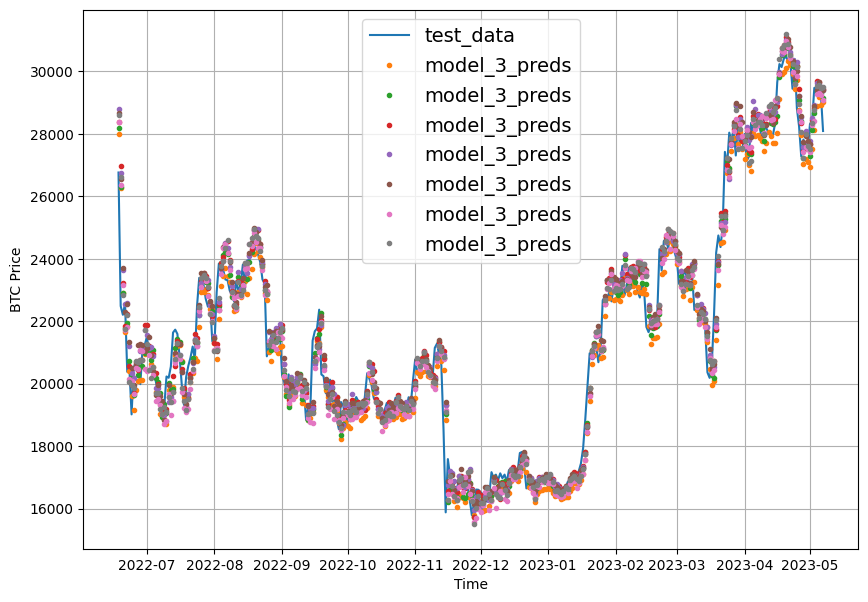

In [75]:
# Plot the model_3_preds
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 format="-",
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_3_preds,
                 start=offset,
                 label='model_3_preds')

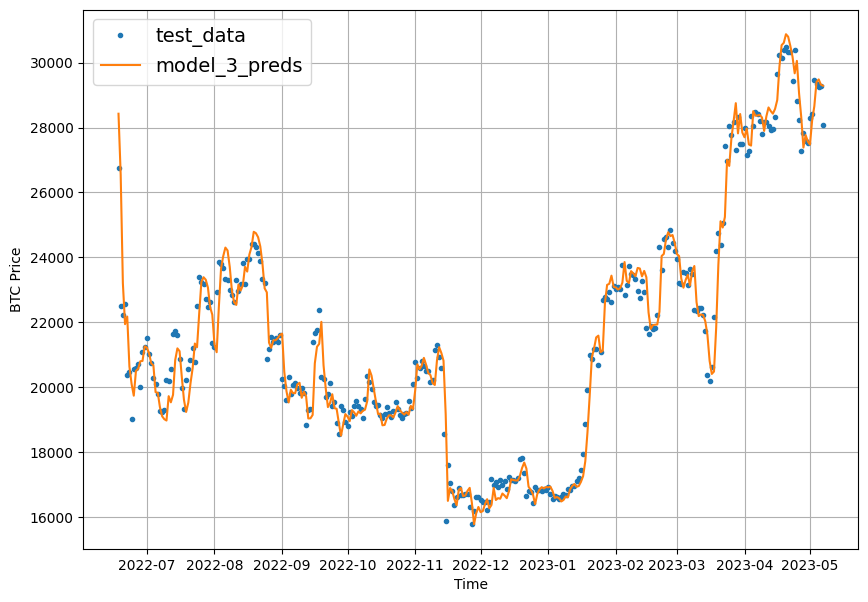

In [76]:
# Plot the model_3_preds - AGGREGATED VERSION 
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label='model_3_preds')

## Which of our models performs the best so far?

<Axes: >

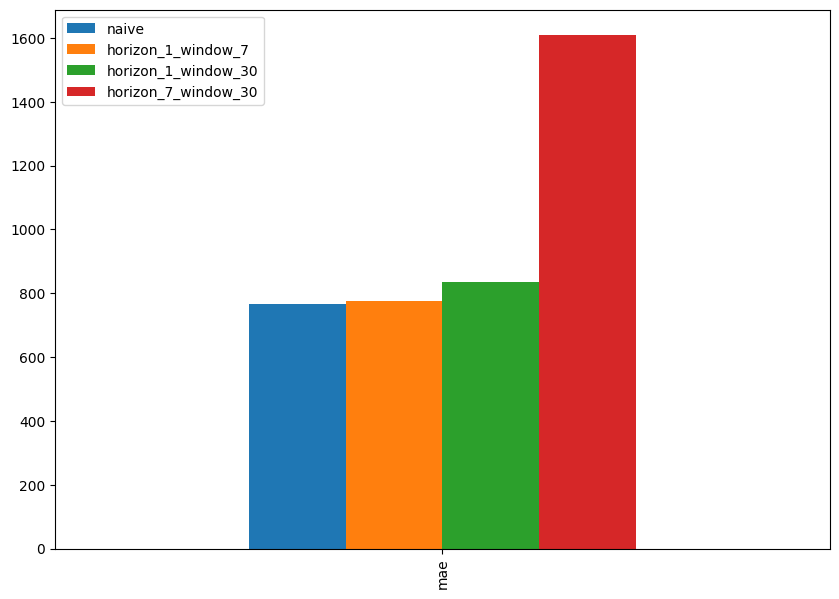

In [77]:
pd.DataFrame({'naive': naive_results['mae'],
              'horizon_1_window_7': model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']},
             index=['mae']).plot(figsize=(10,7), kind='bar')

## Model 4: Conv1D

In [78]:
HORIZON = 1 # predict next day...
WINDOW_SIZE = 7 # ...based on the week before

In [79]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(3148, 3148)

In [80]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, 
                                                                               full_labels,
                                                                               test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

To use a Conv1D input layer, we need an input shape of `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet.

In [81]:
# Check data input shape
train_windows[0].shape

(7,)

In [82]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

In [83]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for input_dim

In [84]:
# Test out the Lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}") # WINDOWS_SIZE, INPUT_DIM
print(f"Original values with expanded shape: {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: [[457.334]
 [424.44 ]
 [394.796]
 [408.904]
 [398.821]
 [402.152]
 [435.791]]


In [85]:
# Create the Conv1D model
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128,
                  kernel_size=5,
                  strides=1,
                  padding='causal',
                  activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# Compile a model
model_4.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

# Fit the model
model_4.fit(x=train_windows,
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])


Epoch 1: val_loss improved from inf to 1425.43164, saving model to model_experiments/model_4_conv1D



Epoch 2: val_loss did not improve from 1425.43164

Epoch 3: val_loss improved from 1425.43164 to 1308.02148, saving model to model_experiments/model_4_conv1D



Epoch 4: val_loss did not improve from 1308.02148

Epoch 5: val_loss improved from 1308.02148 to 1282.55493, saving model to model_experiments/model_4_conv1D



Epoch 6: val_loss improved from 1282.55493 to 1260.36646, saving model to model_experiments/model_4_conv1D



Epoch 7: val_loss did not improve from 1260.36646

Epoch 8: val_loss did not improve from 1260.36646

Epoch 9: val_loss did not improve from 1260.36646

Epoch 10: val_loss improved from 1260.36646 to 1223.33557, saving model to model_experiments/model_4_conv1D



Epoch 11: val_loss improved from 1223.33557 to 1184.95020, saving model to model_experiments/model_4_conv1D



Epoch 12: val_loss did not improve from 1184.95020

Epoch 13: val_loss improved from 1184.95020 to 1158.41663, saving model to model_experiments/model_4_conv1D



Epoch 14: val_loss did not improve from 1158.41663

Epoch 15: val_loss improved from 1158.41663 to 1137.12598, saving model to model_experiments/model_4_conv1D



Epoch 16: val_loss improved from 1137.12598 to 1115.13269, saving model to model_experiments/model_4_conv1D



Epoch 17: val_loss did not improve from 1115.13269

Epoch 18: val_loss did not improve from 1115.13269

Epoch 19: val_loss improved from 1115.13269 to 1079.78137, saving model to model_experiments/model_4_conv1D



Epoch 20: val_loss did not improve from 1079.78137

Epoch 21: val_loss improved from 1079.78137 to 1068.70374, saving model to model_experiments/model_4_conv1D



Epoch 22: val_loss did not improve from 1068.70374

Epoch 23: val_loss improved from 1068.70374 to 1018.50238, saving model to model_experiments/model_4_conv1D



Epoch 24: val_loss did not improve from 1018.50238

Epoch 25: val_loss did not improve from 1018.50238

Epoch 26: val_loss improved from 1018.50238 to 983.51208, saving model to model_experiments/model_4_conv1D



Epoch 27: val_loss did not improve from 983.51208

Epoch 28: val_loss improved from 983.51208 to 948.38275, saving model to model_experiments/model_4_conv1D



Epoch 29: val_loss did not improve from 948.38275

Epoch 30: val_loss improved from 948.38275 to 923.51947, saving model to model_experiments/model_4_conv1D



Epoch 31: val_loss improved from 923.51947 to 916.10980, saving model to model_experiments/model_4_conv1D



Epoch 32: val_loss did not improve from 916.10980

Epoch 33: val_loss did not improve from 916.10980

Epoch 34: val_loss did not improve from 916.10980

Epoch 35: val_loss improved from 916.10980 to 897.32959, saving model to model_experiments/model_4_conv1D



Epoch 36: val_loss did not improve from 897.32959

Epoch 37: val_loss did not improve from 897.32959

Epoch 38: val_loss did not improve from 897.32959

Epoch 39: val_loss did not improve from 897.32959

Epoch 40: val_loss improved from 897.32959 to 880.70514, saving model to model_experiments/model_4_conv1D



Epoch 41: val_loss improved from 880.70514 to 868.14307, saving model to model_experiments/model_4_conv1D



Epoch 42: val_loss improved from 868.14307 to 866.05945, saving model to model_experiments/model_4_conv1D



Epoch 43: val_loss did not improve from 866.05945

Epoch 44: val_loss improved from 866.05945 to 861.01746, saving model to model_experiments/model_4_conv1D



Epoch 45: val_loss improved from 861.01746 to 857.83344, saving model to model_experiments/model_4_conv1D



Epoch 46: val_loss did not improve from 857.83344

Epoch 47: val_loss improved from 857.83344 to 853.77289, saving model to model_experiments/model_4_conv1D



Epoch 48: val_loss did not improve from 853.77289

Epoch 49: val_loss improved from 853.77289 to 849.59583, saving model to model_experiments/model_4_conv1D



Epoch 50: val_loss improved from 849.59583 to 847.23206, saving model to model_experiments/model_4_conv1D



Epoch 51: val_loss did not improve from 847.23206

Epoch 52: val_loss did not improve from 847.23206

Epoch 53: val_loss did not improve from 847.23206

Epoch 54: val_loss improved from 847.23206 to 837.17200, saving model to model_experiments/model_4_conv1D



Epoch 55: val_loss did not improve from 837.17200

Epoch 56: val_loss did not improve from 837.17200

Epoch 57: val_loss did not improve from 837.17200

Epoch 58: val_loss did not improve from 837.17200

Epoch 59: val_loss did not improve from 837.17200

Epoch 60: val_loss improved from 837.17200 to 829.20758, saving model to model_experiments/model_4_conv1D



Epoch 61: val_loss did not improve from 829.20758

Epoch 62: val_loss did not improve from 829.20758

Epoch 63: val_loss did not improve from 829.20758

Epoch 64: val_loss improved from 829.20758 to 828.79102, saving model to model_experiments/model_4_conv1D



Epoch 65: val_loss did not improve from 828.79102

Epoch 66: val_loss did not improve from 828.79102

Epoch 67: val_loss did not improve from 828.79102

Epoch 68: val_loss did not improve from 828.79102

Epoch 69: val_loss did not improve from 828.79102

Epoch 70: val_loss improved from 828.79102 to 818.86212, saving model to model_experiments/model_4_conv1D



Epoch 71: val_loss did not improve from 818.86212

Epoch 72: val_loss improved from 818.86212 to 811.18726, saving model to model_experiments/model_4_conv1D



Epoch 73: val_loss did not improve from 811.18726

Epoch 74: val_loss did not improve from 811.18726

Epoch 75: val_loss did not improve from 811.18726

Epoch 76: val_loss did not improve from 811.18726

Epoch 77: val_loss did not improve from 811.18726

Epoch 78: val_loss did not improve from 811.18726

Epoch 79: val_loss did not improve from 811.18726

Epoch 80: val_loss did not improve from 811.18726

Epoch 81: val_loss did not improve from 811.18726

Epoch 82: val_loss did not improve from 811.18726

Epoch 83: val_loss did not improve from 811.18726

Epoch 84: val_loss did not improve from 811.18726

Epoch 85: val_loss did not improve from 811.18726

Epoch 86: val_loss improved from 811.18726 to 796.86676, saving model to model_experiments/model_4_conv1D



Epoch 87: val_loss did not improve from 796.86676

Epoch 88: val_loss improved from 796.86676 to 794.97662, saving model to model_experiments/model_4_conv1D



Epoch 89: val_loss did not improve from 794.97662

Epoch 90: val_loss did not improve from 794.97662

Epoch 91: val_loss did not improve from 794.97662

Epoch 92: val_loss did not improve from 794.97662

Epoch 93: val_loss did not improve from 794.97662

Epoch 94: val_loss did not improve from 794.97662

Epoch 95: val_loss did not improve from 794.97662

Epoch 96: val_loss did not improve from 794.97662

Epoch 97: val_loss did not improve from 794.97662

Epoch 98: val_loss did not improve from 794.97662

Epoch 99: val_loss did not improve from 794.97662

Epoch 100: val_loss did not improve from 794.97662


In [86]:
# Evaluate model_4
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 843.6370 - mae: 843.6370 - mse: 1598105.3750


[843.6370239257812, 843.6370239257812, 1598105.375]

In [87]:
# Load in the best performing model_4
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1D')
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 794.9765 - mae: 794.9765 - mse: 1480429.7500


[794.9765014648438, 794.9765014648438, 1480429.75]

In [88]:
# Make predictions 
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47143.02 , 46461.645, 44901.727, 44810.496, 46130.66 , 48760.793,
       49196.25 , 49517.58 , 49771.58 , 48256.71 ], dtype=float32)>

In [89]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 794.9766,
 'mse': 1480429.6,
 'rmse': 1216.729,
 'mape': 2.341671,
 'mase': 1.0359418}

In [90]:
model_1_results

{'mae': 775.2205,
 'mse': 1414020.9,
 'rmse': 1189.1261,
 'mape': 2.28088,
 'mase': 1.0101975}

## Model 5: LSTM
Let's create a RNN model for our time series data.

We're going to use the same data we have created for previous experiment.

In [91]:
# Let's create LSTM model using Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
#x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
#x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_LSTM')

# Compile
model_5.compile(loss='mae',
                optimizer='adam')
                #metrics=['mae', 'mse'])

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

Epoch 1/100
19/20 [===========================>..] - ETA: 0s - loss: 6362.4639
Epoch 1: val_loss improved from inf to 15659.05762, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 4s 107ms/step - loss: 6319.4263 - val_loss: 15659.0576
Epoch 2/100
12/20 [=================>............] - ETA: 0s - loss: 3079.7100
Epoch 2: val_loss improved from 15659.05762 to 1635.16235, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 2s 115ms/step - loss: 2236.0347 - val_loss: 1635.1624
Epoch 3/100
11/20 [===============>..............] - ETA: 0s - loss: 807.9265
Epoch 3: val_loss improved from 1635.16235 to 1478.22595, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 2s 116ms/step - loss: 662.9302 - val_loss: 1478.2260
Epoch 4/100
11/20 [===============>..............] - ETA: 0s - loss: 481.3357
Epoch 4: val_loss did not improve from 1478.22595
20/20 [==============================] - 

In [92]:
# Load in the best version of model_5 and evaluate
model_5 = tf.keras.models.load_model('model_experiments/model_5_LSTM')
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 833.6116


833.6116333007812

In [93]:
# Make prediction 
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

20/20 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([47376.58 , 46404.715, 45224.926, 44746.73 , 45724.977],
      dtype=float32)>

In [94]:
# Evaluate model_5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                y_pred=model_5_preds)
model_5_results

{'mae': 833.6115,
 'mse': 1569632.8,
 'rmse': 1252.8499,
 'mape': 2.4609375,
 'mase': 1.0862874}

In [95]:
model_1_results

{'mae': 775.2205,
 'mse': 1414020.9,
 'rmse': 1189.1261,
 'mape': 2.28088,
 'mase': 1.0101975}

## Make a multivariate time series data

Before we add feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...
* day 1 - 0
* day 2 - 1
* day 3 - 0 and so on

What's a better feature to use?

Maybe Bitcon halving events?

In [98]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [109]:
# Let's add Bitcoin halving events to our data
block_reward_1 = 50 # 3 Jan 2009 - this reward isn't in our dataset (start from 17/9/2014)
block_reward_2 = 25 # 28 Nov 2012 - this reward isn't in our dataset, too
block_reward_3 = 12.5 # 9 Jul 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [124]:
# Create date ranges where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(661, 2070)

In [130]:
# Add in block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# Add in block_reward values as a feature to our dataframes
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2023-05-03,29006.308594,6.25
2023-05-04,28847.710938,6.25
2023-05-05,29534.384766,6.25
2023-05-06,28904.623047,6.25
2023-05-07,28897.636719,6.25


<Axes: xlabel='Date'>

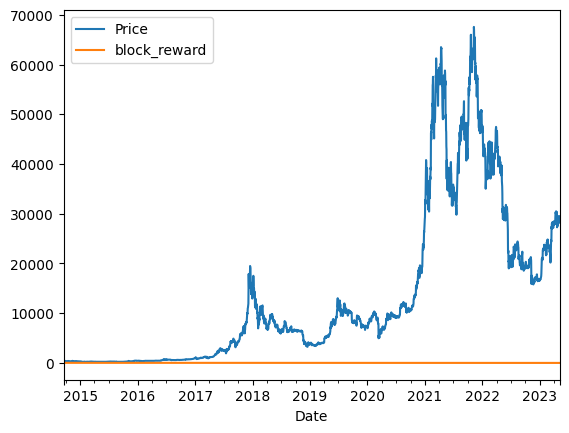

In [134]:
bitcoin_prices_block.plot()

<Axes: xlabel='Date'>

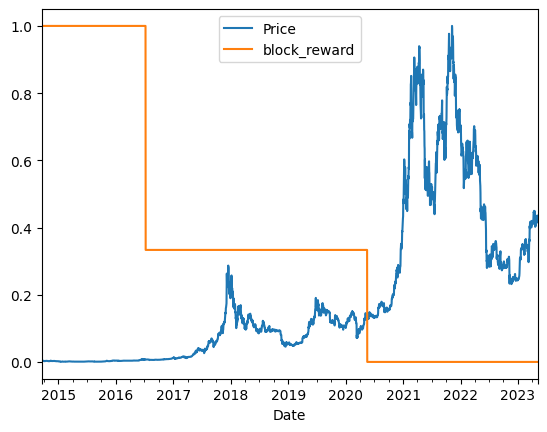

In [135]:
# Plot the block_reward vs price overtime
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot()

## Making a windowed dataset with `Pandas`
Previously we've turned our univariate time series into windowed dataset using helper functions above.

However, since we'ge got multivariate now, these functions won't work.

Not to worry, we can use the `pandas.DataFrame.shift()` method to window our multivariate data. 

In [136]:
# Setup hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [137]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): #shift values for each step in window size
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed['Price'].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


What we've done is create a way to window our dataset directly from a `pandas.DataFrame`.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
...
```

In [138]:
# Create X (windows) and y (horizon) features
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)
X.head(), y.head()

(            block_reward     Price+1     Price+2     Price+3     Price+4  \
 Date                                                                       
 2014-09-24          25.0  435.790985  402.152008  398.821014  408.903992   
 2014-09-25          25.0  423.204987  435.790985  402.152008  398.821014   
 2014-09-26          25.0  411.574005  423.204987  435.790985  402.152008   
 2014-09-27          25.0  404.424988  411.574005  423.204987  435.790985   
 2014-09-28          25.0  399.519989  404.424988  411.574005  423.204987   
 
                Price+5     Price+6     Price+7  
 Date                                            
 2014-09-24  394.795990  424.440002  457.334015  
 2014-09-25  408.903992  394.795990  424.440002  
 2014-09-26  398.821014  408.903992  394.795990  
 2014-09-27  402.152008  398.821014  408.903992  
 2014-09-28  435.790985  402.152008  398.821014  ,
 Date
 2014-09-24    423.204987
 2014-09-25    411.574005
 2014-09-26    404.424988
 2014-09-27    399.51998

In [139]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2518, 630, 2518, 630)

In [141]:
X_train

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.00,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.00,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.00,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.00,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.00,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014
...,...,...,...,...,...,...,...,...
2021-08-11,6.25,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000,40869.554688,39747.503906
2021-08-12,6.25,45593.636719,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000,40869.554688
2021-08-13,6.25,44428.289062,45593.636719,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000


## Model 6: Dense (but on multivariate data)

In [159]:
tf.random.set_seed(42)

# Make a multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_6_dense_multivariate')

# Compile the model
model_6.compile(loss='mae',
                optimizer='adam')

# Fit the model
model_6.fit(X_train,
            y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
11/20 [===============>..............] - ETA: 0s - loss: 3574.2100 
Epoch 1: val_loss improved from inf to 2481.51440, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 3s 85ms/step - loss: 2451.4739 - val_loss: 2481.5144
Epoch 2/100
11/20 [===============>..............] - ETA: 0s - loss: 582.2496
Epoch 2: val_loss improved from 2481.51440 to 1542.92542, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 50ms/step - loss: 534.4127 - val_loss: 1542.9254
Epoch 3/100
11/20 [===============>..............] - ETA: 0s - loss: 461.7060
Epoch 3: val_loss improved from 1542.92542 to 1189.96191, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 47ms/step - loss: 419.6844 - val_loss: 1189.9619
Epoch 4/100
15/20 [=====================>........] - ETA: 0s - loss: 366.3287
Epoch 4: val_loss improved from 1189.96191 to 1045.07141, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 36ms/step - loss: 381.9458 - val_loss: 1045.0714
Epoch 5/100
17/20 [========================>.....] - ETA: 0s - loss: 347.6124
Epoch 5: val_loss improved from 1045.07141 to 947.24982, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 35ms/step - loss: 342.2640 - val_loss: 947.2498
Epoch 6/100
17/20 [========================>.....] - ETA: 0s - loss: 318.1710
Epoch 6: val_loss improved from 947.24982 to 906.66547, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 35ms/step - loss: 328.1006 - val_loss: 906.6655
Epoch 7/100
14/20 [====================>.........] - ETA: 0s - loss: 323.6184
Epoch 7: val_loss did not improve from 906.66547
20/20 [==============================] - 0s 6ms/step - loss: 328.1672 - val_loss: 998.2936
Epoch 8/100
17/20 [========================>.....] - ETA: 0s - loss: 322.6658
Epoch 8: val_loss improved from 906.66547 to 895.72632, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 34ms/step - loss: 318.2098 - val_loss: 895.7263
Epoch 9/100
18/20 [==========================>...] - ETA: 0s - loss: 319.5474
Epoch 9: val_loss did not improve from 895.72632
20/20 [==============================] - 0s 5ms/step - loss: 313.9386 - val_loss: 991.6090
Epoch 10/100
18/20 [==========================>...] - ETA: 0s - loss: 290.0416
Epoch 10: val_loss improved from 895.72632 to 880.34283, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 35ms/step - loss: 291.0751 - val_loss: 880.3428
Epoch 11/100
18/20 [==========================>...] - ETA: 0s - loss: 313.9966
Epoch 11: val_loss improved from 880.34283 to 836.19800, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 34ms/step - loss: 323.1430 - val_loss: 836.1980
Epoch 12/100
19/20 [===========================>..] - ETA: 0s - loss: 316.8662
Epoch 12: val_loss improved from 836.19800 to 832.36407, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 34ms/step - loss: 314.1612 - val_loss: 832.3641
Epoch 13/100
18/20 [==========================>...] - ETA: 0s - loss: 286.5667
Epoch 13: val_loss improved from 832.36407 to 827.21002, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 34ms/step - loss: 287.0393 - val_loss: 827.2100
Epoch 14/100
17/20 [========================>.....] - ETA: 0s - loss: 272.6618
Epoch 14: val_loss did not improve from 827.21002
20/20 [==============================] - 0s 6ms/step - loss: 279.7987 - val_loss: 970.8861
Epoch 15/100
18/20 [==========================>...] - ETA: 0s - loss: 318.3066
Epoch 15: val_loss did not improve from 827.21002
20/20 [==============================] - 0s 5ms/step - loss: 316.1591 - val_loss: 1108.5245
Epoch 16/100
18/20 [==========================>...] - ETA: 0s - loss: 297.5560
Epoch 16: val_loss did not improve from 827.21002
20/20 [==============================] - 0s 5ms/step - loss: 306.8578 - val_loss: 1186.5516
Epoch 17/100
19/20 [===========================>..] - ETA: 0s - loss: 299.9175
Epoch 17: val_loss improved from 827.21002 to 805.07007, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 34ms/step - loss: 297.3782 - val_loss: 805.0701
Epoch 18/100
18/20 [==========================>...] - ETA: 0s - loss: 270.0850
Epoch 18: val_loss improved from 805.07007 to 805.01514, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 35ms/step - loss: 271.1192 - val_loss: 805.0151
Epoch 19/100
17/20 [========================>.....] - ETA: 0s - loss: 279.3938
Epoch 19: val_loss did not improve from 805.01514
20/20 [==============================] - 0s 5ms/step - loss: 277.9758 - val_loss: 1204.4504
Epoch 20/100
17/20 [========================>.....] - ETA: 0s - loss: 342.3367
Epoch 20: val_loss did not improve from 805.01514
20/20 [==============================] - 0s 5ms/step - loss: 343.8983 - val_loss: 912.5286
Epoch 21/100
16/20 [=======================>......] - ETA: 0s - loss: 340.4743
Epoch 21: val_loss did not improve from 805.01514
20/20 [==============================] - 0s 6ms/step - loss: 328.2881 - val_loss: 1044.8597
Epoch 22/100
17/20 [========================>.....] - ETA: 0s - loss: 271.0475
Epoch 22: val_loss did not improve from 805.01514
20/20 [==============================] - 0s 6ms/step - loss: 277.7644 - val_loss: 846.1501
Epoch 23/100
18/20 [======

20/20 [==============================] - 1s 35ms/step - loss: 291.4624 - val_loss: 798.5735
Epoch 25/100
17/20 [========================>.....] - ETA: 0s - loss: 281.1855
Epoch 25: val_loss improved from 798.57355 to 794.95557, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 34ms/step - loss: 267.4749 - val_loss: 794.9556
Epoch 26/100
15/20 [=====================>........] - ETA: 0s - loss: 265.5669
Epoch 26: val_loss did not improve from 794.95557
20/20 [==============================] - 0s 6ms/step - loss: 277.4905 - val_loss: 885.0958
Epoch 27/100
17/20 [========================>.....] - ETA: 0s - loss: 265.9664
Epoch 27: val_loss did not improve from 794.95557
20/20 [==============================] - 0s 5ms/step - loss: 275.9155 - val_loss: 952.6415
Epoch 28/100
17/20 [========================>.....] - ETA: 0s - loss: 272.9908
Epoch 28: val_loss improved from 794.95557 to 787.90540, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 43ms/step - loss: 266.1091 - val_loss: 787.9054
Epoch 29/100
13/20 [==================>...........] - ETA: 0s - loss: 267.9571
Epoch 29: val_loss did not improve from 787.90540
20/20 [==============================] - 0s 8ms/step - loss: 264.5497 - val_loss: 796.3133
Epoch 30/100
12/20 [=================>............] - ETA: 0s - loss: 291.6290
Epoch 30: val_loss did not improve from 787.90540
20/20 [==============================] - 0s 7ms/step - loss: 277.9810 - val_loss: 808.3809
Epoch 31/100
12/20 [=================>............] - ETA: 0s - loss: 288.6868
Epoch 31: val_loss did not improve from 787.90540
20/20 [==============================] - 0s 7ms/step - loss: 277.4680 - val_loss: 802.8896
Epoch 32/100
13/20 [==================>...........] - ETA: 0s - loss: 262.9484
Epoch 32: val_loss did not improve from 787.90540
20/20 [==============================] - 0s 7ms/step - loss: 271.3372 - val_loss: 960.9861
Epoch 33/100
13/20 [========

20/20 [==============================] - 1s 78ms/step - loss: 272.8374 - val_loss: 786.9465
Epoch 34/100
13/20 [==================>...........] - ETA: 0s - loss: 270.7494
Epoch 34: val_loss did not improve from 786.94647
20/20 [==============================] - 0s 8ms/step - loss: 262.6955 - val_loss: 789.8993
Epoch 35/100
12/20 [=================>............] - ETA: 0s - loss: 257.2739
Epoch 35: val_loss did not improve from 786.94647
20/20 [==============================] - 0s 8ms/step - loss: 271.6225 - val_loss: 869.7608
Epoch 36/100
20/20 [==============================] - ETA: 0s - loss: 283.2364
Epoch 36: val_loss did not improve from 786.94647
20/20 [==============================] - 0s 9ms/step - loss: 283.2364 - val_loss: 1007.3859
Epoch 37/100
13/20 [==================>...........] - ETA: 0s - loss: 281.0236
Epoch 37: val_loss improved from 786.94647 to 785.16882, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 45ms/step - loss: 287.6565 - val_loss: 785.1688
Epoch 38/100
17/20 [========================>.....] - ETA: 0s - loss: 253.1283
Epoch 38: val_loss did not improve from 785.16882
20/20 [==============================] - 0s 5ms/step - loss: 267.9386 - val_loss: 905.9545
Epoch 39/100
18/20 [==========================>...] - ETA: 0s - loss: 276.9199
Epoch 39: val_loss did not improve from 785.16882
20/20 [==============================] - 0s 6ms/step - loss: 279.6696 - val_loss: 785.8865
Epoch 40/100
17/20 [========================>.....] - ETA: 0s - loss: 307.5262
Epoch 40: val_loss did not improve from 785.16882
20/20 [==============================] - 0s 5ms/step - loss: 309.4582 - val_loss: 838.2438
Epoch 41/100
17/20 [========================>.....] - ETA: 0s - loss: 274.9194
Epoch 41: val_loss did not improve from 785.16882
20/20 [==============================] - 0s 5ms/step - loss: 276.7553 - val_loss: 788.0653
Epoch 42/100
18/20 [========

20/20 [==============================] - 1s 36ms/step - loss: 270.3864 - val_loss: 783.5765
Epoch 49/100
18/20 [==========================>...] - ETA: 0s - loss: 284.2968
Epoch 49: val_loss did not improve from 783.57648
20/20 [==============================] - 0s 5ms/step - loss: 279.9064 - val_loss: 950.9816
Epoch 50/100
18/20 [==========================>...] - ETA: 0s - loss: 298.2528
Epoch 50: val_loss did not improve from 783.57648
20/20 [==============================] - 0s 6ms/step - loss: 302.6921 - val_loss: 793.6034
Epoch 51/100
18/20 [==========================>...] - ETA: 0s - loss: 278.9207
Epoch 51: val_loss did not improve from 783.57648
20/20 [==============================] - 0s 5ms/step - loss: 276.8394 - val_loss: 852.7178
Epoch 52/100
19/20 [===========================>..] - ETA: 0s - loss: 275.9745
Epoch 52: val_loss did not improve from 783.57648
20/20 [==============================] - 0s 5ms/step - loss: 275.4656 - val_loss: 887.8637
Epoch 53/100
11/20 [========

20/20 [==============================] - 1s 34ms/step - loss: 272.6884 - val_loss: 780.8179
Epoch 61/100
17/20 [========================>.....] - ETA: 0s - loss: 263.9173
Epoch 61: val_loss did not improve from 780.81793
20/20 [==============================] - 0s 5ms/step - loss: 264.1674 - val_loss: 787.3820
Epoch 62/100
17/20 [========================>.....] - ETA: 0s - loss: 268.4158
Epoch 62: val_loss did not improve from 780.81793
20/20 [==============================] - 0s 6ms/step - loss: 268.2518 - val_loss: 879.4924
Epoch 63/100
18/20 [==========================>...] - ETA: 0s - loss: 265.9810
Epoch 63: val_loss did not improve from 780.81793
20/20 [==============================] - 0s 5ms/step - loss: 275.2357 - val_loss: 953.1142
Epoch 64/100
18/20 [==========================>...] - ETA: 0s - loss: 319.9282
Epoch 64: val_loss did not improve from 780.81793
20/20 [==============================] - 0s 6ms/step - loss: 322.1804 - val_loss: 971.6234
Epoch 65/100
17/20 [========

In [147]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 5ms/step - loss: 857.7116


857.7116088867188

In [148]:
# Load best performing model
model_6 = tf.keras.models.load_model('model_experiments/model_6_dense_multivariate')
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 803.3663


803.3662719726562

In [150]:
# Make predictions
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([46840.13 , 46458.934, 44762.543, 44248.883, 46082.285, 48700.49 ,
       49100.383, 49514.21 , 49830.543, 47838.254], dtype=float32)>

In [157]:
# Evaluate predictions to get metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 803.3664,
 'mse': 1483021.5,
 'rmse': 1217.7937,
 'mape': 2.35794,
 'mase': 1.0468746}